In [6]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

!whoami
!date

alibow
Wed Jul  8 13:27:11 PDT 2020


In [12]:
# define output directories and location names

# NOTE: this current output directory is the INCOMPLETE results folder for Ethiopia
# these results were what was presented to BMGF
# there is a complete results directory, however the state_person_time.hdf dataframe 
    # in this directory is not stratified by year, which is required for many plots, 
    # so it is not used in this notebook, but should be updated in the future.

output_dirs = ['/share/costeffectiveness/results/vivarium_conic_lsff/ethiopia/2020_06_28_12_40_56/count_data_incomplete/',
               '/share/costeffectiveness/results/vivarium_conic_lsff/india/2020_06_26_20_35_00/count_data/',
              '/share/costeffectiveness/results/vivarium_conic_lsff/nigeria/2020_06_26_20_28_27/count_data/']

locations = ['Ethiopia','India','Nigeria']

In [26]:
# this function reads deaths, ylds, and ylls (and dalys) from results directories and calculates
# averted results for each intervention scenario relative to the baseline scenario in RATE SPACE
# stratified by the specified variables

# this function returns a results dataframe that is still stratified by input draw

def get_stratified_averted_results(strata_cols):
    master_data = pd.DataFrame()
    master_pt = pd.DataFrame()
    
    # repeat for each location
    for i in range(len(output_dirs)):
        data = pd.DataFrame()
        # read in data for each measure listed here
        for measure in ['deaths','ylls','ylds']:
            temp = pd.read_hdf(output_dirs[i] + measure + '.hdf')
            temp['measure'] = measure
            data = data.append(temp)
            
        # sum ylds and ylls to calculate dalys and merge back into dataframe
        dalys = data.loc[data.measure.isin(['ylls','ylds'])]
        dalys = dalys.groupby([col for col in dalys.columns if col not in ['measure','value']]).sum().reset_index()
        dalys['measure'] = 'dalys'
        data = data.append(dalys)
        data['location'] = locations[i]
        master_data = master_data.append(data)
        
        # use state person time here because there was an issue in person_time.hdf for India and Nigeria
        pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
        pt = pt.loc[pt.cause.str.contains('diarrheal')]
        pt['location'] = locations[i]
        master_pt = master_pt.append(pt)
        
    # remove 2020 from dataset if not stratifying by year (so that we do not include the year before scale up begins in results)
    if 'year' not in strata_cols:
        master_data = master_data.loc[master_data.year != '2020']
        master_pt = master_pt.loc[master_pt.year != '2020']
        
    # sum event counts over input draws and stratifying variables
    master_data = master_data.groupby((['location','scenario','input_draw'] + strata_cols + ['measure'])).sum()
    
    # sum person time over input draws and stratifying variables
    # with excpetion because person time dataframe does not have a cause column
    if 'cause' in strata_cols:
        no_cause_strata_cols = [col for col in strata_cols if col != 'cause']
        master_pt = master_pt.groupby(['location','scenario','input_draw'] + no_cause_strata_cols).sum()
    else:    
        master_pt = master_pt.groupby((['location','scenario','input_draw'] + strata_cols)).sum()
    
    # covert to rate space
    rates = master_data / master_pt
    baseline_rates = rates.reset_index()
    baseline_rates = baseline_rates.loc[baseline_rates.scenario == 'baseline']
    baseline_rates = baseline_rates.set_index((['location','input_draw'] + strata_cols + ['measure'])).drop(columns='scenario')
    rates = rates.reset_index().set_index((['location','input_draw'] + strata_cols + ['measure','scenario']))
    # calculate averted rates per 100,000 person years
    averted_rates = (baseline_rates - rates) * 100_000
    averted_rates = averted_rates.reset_index()
    averted_rates = averted_rates.loc[averted_rates.scenario != 'baseline']  
    return averted_rates

In [16]:
# calculate overall averted results by location, scenario, input draw, and measure
# note: this dataframe excludes 2020 from the results calculation

overall = get_stratified_averted_results([])
overall.head(10)

,location,input_draw,measure,scenario,value
1,Ethiopia,29,dalys,folic_acid_fortification_scale_up,3.751256e-02
2,Ethiopia,29,dalys,iron_folic_acid_fortification_scale_up,1.611774e+01
3,Ethiopia,29,dalys,vitamin_a_fortification_scale_up,1.378860e+03
5,Ethiopia,29,deaths,folic_acid_fortification_scale_up,-5.204170e-13
6,Ethiopia,29,deaths,iron_folic_acid_fortification_scale_up,-5.204170e-13
7,Ethiopia,29,deaths,vitamin_a_fortification_scale_up,1.342893e+01
9,Ethiopia,29,ylds,folic_acid_fortification_scale_up,3.751256e-02
10,Ethiopia,29,ylds,iron_folic_acid_fortification_scale_up,1.611774e+01
11,Ethiopia,29,ylds,vitamin_a_fortification_scale_up,2.249344e+02
13,Ethiopia,29,ylls,folic_acid_fortification_scale_up,-8.881784e-11


In [17]:
by_year = get_stratified_averted_results(['year'])
by_year.head()

,location,input_draw,year,measure,scenario,value
1,Ethiopia,29,2020,dalys,folic_acid_fortification_scale_up,0.000000e+00
2,Ethiopia,29,2020,dalys,iron_folic_acid_fortification_scale_up,0.000000e+00
3,Ethiopia,29,2020,dalys,vitamin_a_fortification_scale_up,1.110223e-11
5,Ethiopia,29,2020,deaths,folic_acid_fortification_scale_up,0.000000e+00
6,Ethiopia,29,2020,deaths,iron_folic_acid_fortification_scale_up,0.000000e+00


In [19]:
by_cause = get_stratified_averted_results(['cause'])
by_cause.head()

,location,input_draw,cause,measure,scenario,value
1,Ethiopia,29,diarrheal_diseases,dalys,folic_acid_fortification_scale_up,-1.110223e-11
2,Ethiopia,29,diarrheal_diseases,dalys,iron_folic_acid_fortification_scale_up,-8.326673e-12
3,Ethiopia,29,diarrheal_diseases,dalys,vitamin_a_fortification_scale_up,8.063932e+02
5,Ethiopia,29,diarrheal_diseases,deaths,folic_acid_fortification_scale_up,-8.673617e-14
6,Ethiopia,29,diarrheal_diseases,deaths,iron_folic_acid_fortification_scale_up,-8.673617e-14


In [20]:
# this code was used to fill in the table for Nigeria that was presented to BMGF

for_table = by_cause.loc[by_cause.measure == 'dalys']
for_table = for_table.loc[for_table.location == 'Nigeria']
for_table = for_table.groupby(['scenario','cause']).describe(percentiles=[0.025,0.1,0.9,0.975])
for_table['value','90%']

scenario                                cause                       
folic_acid_fortification_scale_up       diarrheal_diseases                0.249154
                                        iron_deficiency                   0.009318
                                        lower_respiratory_infections      4.480013
                                        measles                           0.052038
                                        neural_tube_defects              86.339024
                                        other_causes                      7.949372
                                        vitamin_a_deficiency              0.003560
iron_folic_acid_fortification_scale_up  diarrheal_diseases                7.477442
                                        iron_deficiency                  63.467969
                                        lower_respiratory_infections     14.816684
                                        measles                           0.117850
                  

In [21]:
by_year_and_cause = get_stratified_averted_results(['year','cause'])
by_year_and_cause.head()

,location,input_draw,year,cause,measure,scenario,value
1,Ethiopia,29,2020,diarrheal_diseases,dalys,folic_acid_fortification_scale_up,2.775558e-12
2,Ethiopia,29,2020,diarrheal_diseases,dalys,iron_folic_acid_fortification_scale_up,0.000000e+00
3,Ethiopia,29,2020,diarrheal_diseases,dalys,vitamin_a_fortification_scale_up,2.775558e-12
5,Ethiopia,29,2020,diarrheal_diseases,deaths,folic_acid_fortification_scale_up,0.000000e+00
6,Ethiopia,29,2020,diarrheal_diseases,deaths,iron_folic_acid_fortification_scale_up,0.000000e+00


# PLOTTING

The current plotting code uses 80% confidence intervals. This can be changed by altering the 0.1 (10%) and 0.9 (90%) percentiles in these functions. 

Each plotting function will automatically save a plot (or plots) with a (somewhat) descriptive title to the working directory. If you don't want to save plots, the "savefig" line can be easily commented out.

## 1. Overall Results (uses *overall* dataframe)

In [27]:
# bar chart with averted outcomes in rate space - each scenario and each location (9 bars)
# can choose deaths, dalys, ylls, ylds

def make_averted_outcome_bar_chart_for_each_location_and_scenario(measure):
    
    data = pd.DataFrame.copy(overall)
    
    # bar width
    barWidth = 0.25
    
    data = data.loc[data.measure == measure]
        
    data = data.groupby(['location','scenario']).describe(percentiles=[0.1,0.9]).reset_index().sort_values(by='location')
    data1 = data.loc[data.scenario == 'vitamin_a_fortification_scale_up']
    data2 = data.loc[data.scenario == 'folic_acid_fortification_scale_up']
    data3 = data.loc[data.scenario == 'iron_folic_acid_fortification_scale_up']

    data1_mean = data1['value','mean']
    data2_mean = data2['value','mean']
    data3_mean = data3['value','mean']
    
    data1_min = data1['value','mean'] - data1['value','10%']
    data2_min = data2['value','mean'] - data2['value','10%']
    data3_min = data3['value','mean'] - data3['value','10%']
    
    data1_max = data1['value','90%'] - data1['value','mean']
    data2_max = data2['value','90%'] - data2['value','mean']
    data3_max = data3['value','90%'] - data3['value','mean']

    a = np.arange(len(data1))
    b = [x + barWidth for x in a]
    c = [x + barWidth for x in b]

    plt.bar(a, data1_mean, width=barWidth, yerr = [data1_min,data1_max])
    plt.bar(b, data2_mean, width=barWidth, yerr = [data2_min,data2_max])
    plt.bar(c, data3_mean, width=barWidth, yerr = [data3_min,data3_max])
    
    if measure == 'dalys':
        measure_title = 'Disability Adjusted Life Years (DALYs)'
    elif measure == 'ylds':
        measure_title = 'Years Lived With Disability (YLDs)'
    elif measure == 'ylls':
        measure_title = 'Years of Life Lost (YLLs)'
    else:
        measure_title = 'Deaths'
    
    plt.xticks([r + barWidth for r in range(len(data1))], np.unique(data1['location']))
    plt.ylabel(f'{measure_title}\n Averted per 100,000 PYs')
    plt.legend(['Vitamin A',
               'Folic Acid',
               'Iron Folic Acid'])
    plt.title(f'{measure_title} Averted \n per 100,000 Person-Years')
    plt.tight_layout()
    plt.savefig(f'bar_chart_{measure}_averted_for_each_location_and_scenario')

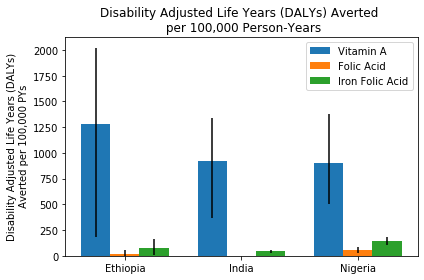

In [28]:
make_averted_outcome_bar_chart_for_each_location_and_scenario('dalys')

In [29]:
# bar chart for a single scenario that shows averted DALYs in rate space for each location (3 bars) and uncertainty

def make_dalys_averted_bar_chart_for_single_scenario(scenario):
    
    data = overall.loc[overall.scenario == scenario]
    dalys = data.loc[data.measure == 'dalys']
    dalys = dalys.groupby(['location','scenario']).describe(percentiles=[0.1,0.9]).reset_index()
    a = np.arange(len(dalys))
    
    dalys_mean = dalys['value','mean']
    dalys_min = dalys['value','mean'] - dalys['value','10%']
    dalys_max = dalys['value','90%'] - dalys['value','mean']
    plt.bar(a, dalys_mean, yerr = [dalys_min,dalys_max])
    
    scenario_title = scenario.replace('_',' ').capitalize()

    plt.xticks([r for r in range(len(dalys))], np.unique(dalys['location']))
    plt.ylabel('DALYs Averted per 100,000 Person Years')
    plt.title(f'{scenario_title}\n Disability Adjusted Life Years (DALYs)\n Averted per 100,000 Person Years')
    plt.tight_layout()
    plt.savefig(f'bar_chart_dalys_averted_{scenario}')

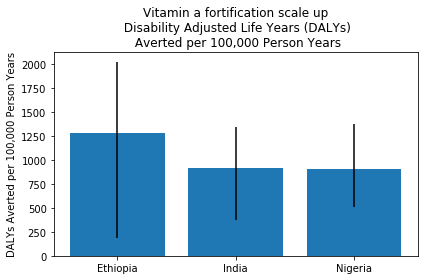

In [30]:
make_dalys_averted_bar_chart_for_single_scenario('vitamin_a_fortification_scale_up')

In [31]:
# stacked bar chart for a single scenario that shows averted DALYs in rate space separated by YLLs and YLDS
# for each location (3 bars). Uncertainty bars were removed because they were hard to interpret in the stacked format

def make_stacked_bar_chart_for_single_scenario(scenario):
    
    data = overall.loc[overall.scenario == scenario]
    ylds = data.loc[data.measure == 'ylds']
    ylds = ylds.groupby(['location','scenario']).describe().reset_index().sort_values(by='location')
    dalys = data.loc[data.measure == 'dalys']
    dalys = dalys.groupby(['location','scenario']).describe().reset_index().sort_values(by='location')
    a = np.arange(len(ylds))
    plt.bar(a, dalys['value','mean'])
    plt.bar(a, ylds['value','mean'])

    scenario_title = scenario.replace('_',' ').capitalize()
    
    plt.xticks([r for r in range(len(ylds))], np.unique(ylds['location']))
    plt.ylabel('DALYs Averted per 100,000 Person Years')
    plt.title(f'{scenario_title}\n Disability Adjusted Life Years (DALYs)\n Averted per 100,000 Person Years')
    plt.legend(['YLLs','YLDs'])
    plt.tight_layout()
    plt.savefig(f'bar_chart_stacked_dalys_averted_{scenario}')

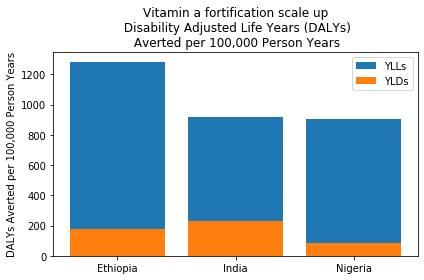

In [34]:
make_stacked_bar_chart_for_single_scenario('vitamin_a_fortification_scale_up')

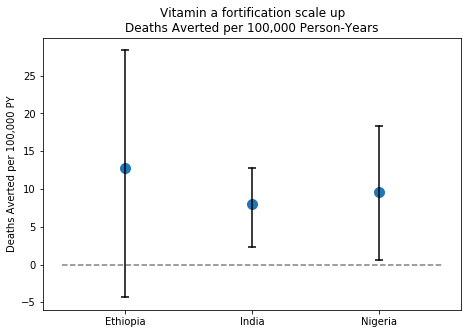

In [57]:
# dot plots as alternative to bar charts

def make_multiple_dot_plots(dataset, scenarios, outcome_vars):
    
    for scenario in scenarios:
        for outcome_var in outcome_vars:
    
            data = dataset.loc[dataset.scenario == scenario]
            data = data.loc[data.measure == outcome_var]
            data = data.groupby(['location']).describe()
    
            if outcome_var == 'dalys':
                outcome_name_long = 'Disability Adjusted Life Years'
                outcome_name_short = 'DALYs'
            elif outcome_var == 'ylls':
                outcome_name_long = 'Years of Life Lost'
                outcome_name_short = 'YLLs'
            elif outcome_var == 'ylds':
                outcome_name_long = 'Years Lived with Disability'
                outcome_name_short = 'YLDs'
            else:
                outcome_name_long = 'Deaths'
                outcome_name_short = 'Deaths'
        
            pos1 = 0.2
            pos2 = 0.4
            pos3 = 0.6    
            
            fig, ax = plt.subplots(figsize=(7.5, 5))

            plt.plot([(pos1 - 0.1),(pos3 + 0.1)],[0,0],'--',c='grey')

            plt.plot([pos1,pos1],[data['value','min'][0],data['value','max'][0]],c='black')
            plt.plot([pos2,pos2],[data['value','min'][1],data['value','max'][1]],c='black')
            plt.plot([pos3,pos3],[data['value','min'][2],data['value','max'][2]],c='black')
            plt.scatter([pos1,pos2,pos3],data['value','min'], marker='_',c='black',s=50)
            plt.scatter([pos1,pos2,pos3],data['value','max'], marker='_',c='black',s=50)         
            plt.scatter([pos1,pos2,pos3],data['value','mean'], s=100)
            
            scenario_title = scenario.replace('_',' ').capitalize()

            plt.xticks([pos1,pos2,pos3], data.index)
            if outcome_var == 'deaths':
                plt.title(f'{scenario_title}\n{outcome_name_long} Averted per 100,000 Person-Years')
            else:
                plt.title(f'{scenario_title}\n{outcome_name_long} ({outcome_name_short}) Averted per 100,000 Person-Years')
            plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')
            
scenarios = ['vitamin_a_fortification_scale_up']#,'folic_acid_fortification_scale_up',
            #'iron_folic_acid_fortification_scale_up']

outcome_vars = ['deaths']#,'ylls','ylds','dalys']
make_multiple_dot_plots(overall, scenarios, outcome_vars)

## 2. Results stratified by year (not by cause. uses *by_year* dataframe)

In [35]:
# these plots show averted outcomes over time
# they plot a single scenario and measure and have multiple lines per location

def make_multiple_plots_by_year_with_uncertainty(dataset, scenarios, outcome_vars):
    for scenario in scenarios:
        for outcome_var in outcome_vars:
            if outcome_var == 'dalys':
                outcome_name_long = 'Disability Adjusted Life Years'
                outcome_name_short = 'DALYs'
            elif outcome_var == 'ylls':
                outcome_name_long = 'Years of Life Lost'
                outcome_name_short = 'YLLs'
            elif outcome_var == 'ylds':
                outcome_name_long = 'Years Lived with Disability'
                outcome_name_short = 'YLDs'
            else:
                outcome_name_long = 'Deaths'
                outcome_name_short = 'Deaths'

            data = dataset.loc[dataset.scenario == scenario]
            data = data.loc[data.measure == outcome_var]
            data = data.groupby(['location','year']).describe(percentiles=[0.1,0.9]).reset_index()

            ethiopia = data.loc[data.location == 'Ethiopia']
            india = data.loc[data.location == 'India']
            nigeria = data.loc[data.location == 'Nigeria']

            fig, ax = plt.subplots(figsize=(7.5, 5))
            
            plt.scatter(ethiopia['year'], ethiopia['value','mean'])
            plt.plot(ethiopia['year'], ethiopia['value','mean'])

            plt.scatter(india['year'], india['value','mean'])
            plt.plot(india['year'], india['value','mean'])

            plt.scatter(nigeria['year'], nigeria['value','mean'])
            plt.plot(nigeria['year'], nigeria['value','mean'])
            
            plt.fill_between(ethiopia['year'],ethiopia['value','90%'],ethiopia['value','10%'], alpha=0.3,color='tab:blue')
            plt.fill_between(india['year'],india['value','90%'],india['value','10%'], alpha=0.3,color='tab:orange')
            plt.fill_between(nigeria['year'],nigeria['value','90%'],nigeria['value','10%'], alpha=0.3,color='tab:green')
            
            scenario_title = scenario.replace('_',' ').capitalize()

            plt.title(f'{scenario_title}\n{outcome_name_long} ({outcome_name_short}) Averted per 100,000 Person-Years')
            plt.legend(['Ethiopia','India','Nigeria'])
            plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')
            plt.tight_layout()
            plt.savefig(f'{scenario}_overall_{outcome_var}_by_location.png')

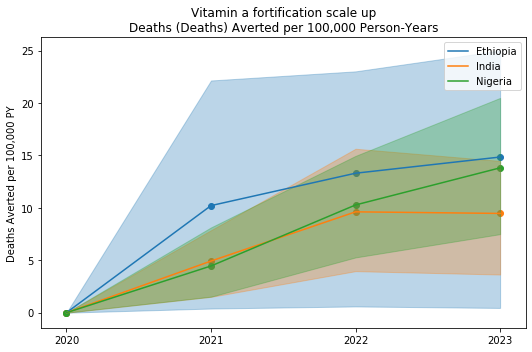

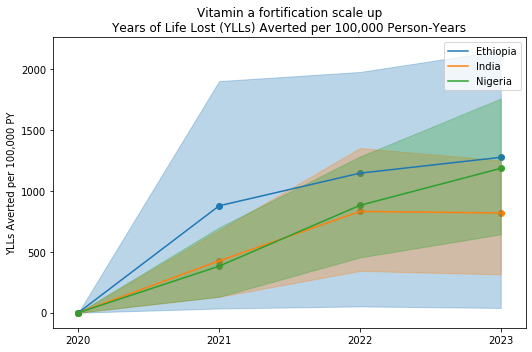

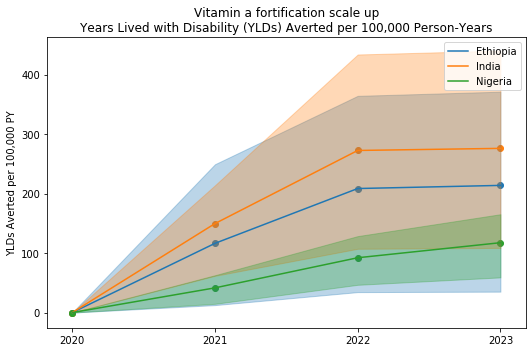

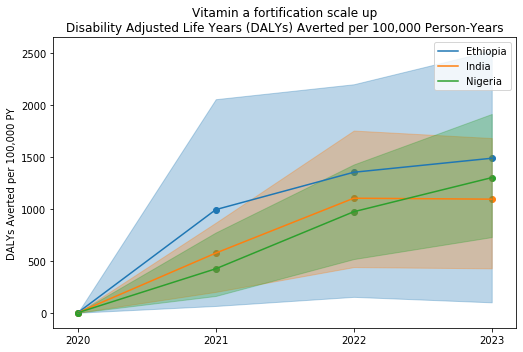

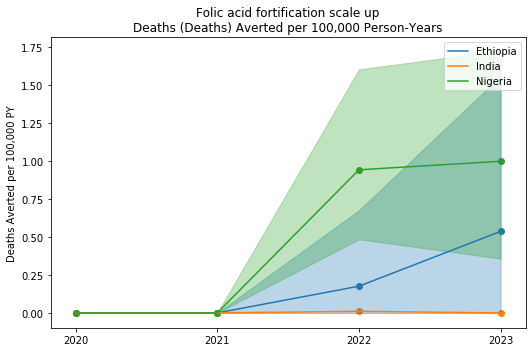

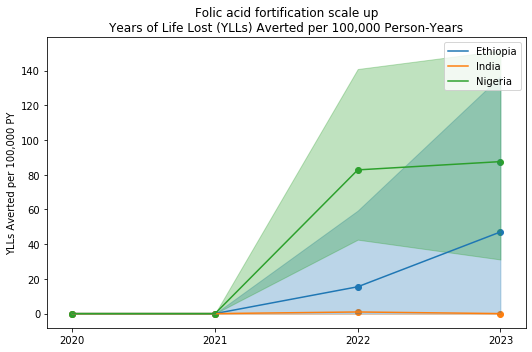

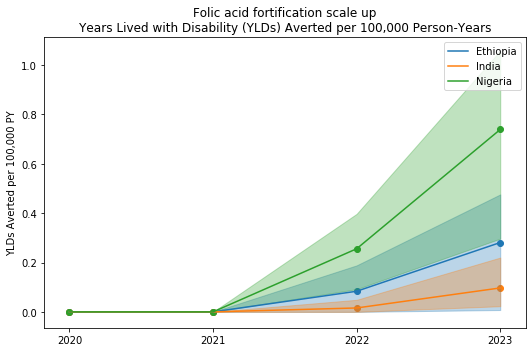

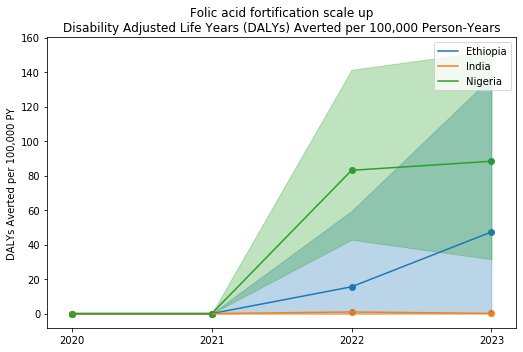

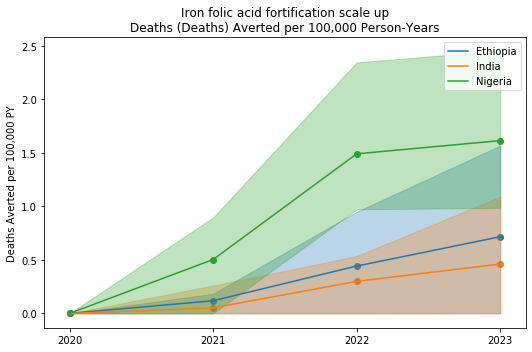

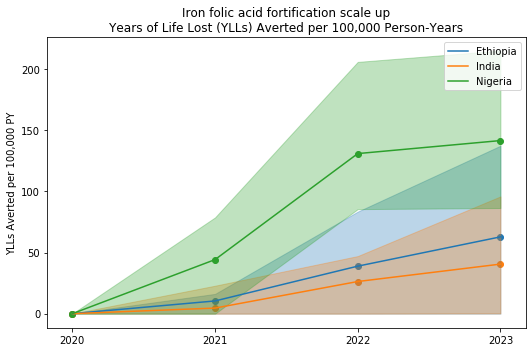

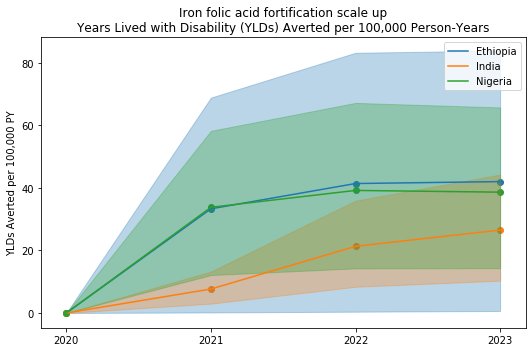

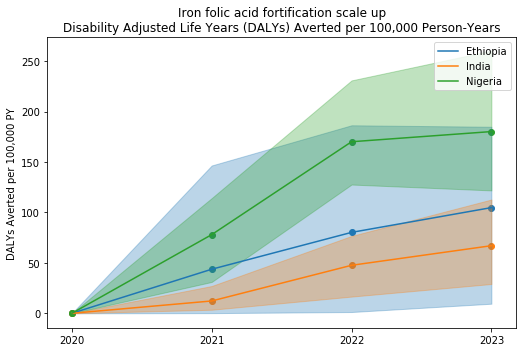

In [36]:
scenarios = ['vitamin_a_fortification_scale_up',
             'folic_acid_fortification_scale_up',
             'iron_folic_acid_fortification_scale_up']

outcome_vars = ['deaths','ylls','ylds','dalys']

make_multiple_plots_by_year_with_uncertainty(by_year, scenarios, outcome_vars)

In [40]:
# these plots show averted outcomes over time
# they plot a single LOCATION and measure and have multiple lines per SCENARIO

def make_multiple_plots_by_year_by_location(dataset, locations, outcome_vars):
    for location in locations:
        for outcome_var in outcome_vars:
            if outcome_var == 'dalys':
                outcome_name_long = 'Disability Adjusted Life Years'
                outcome_name_short = 'DALYs'
            elif outcome_var == 'ylls':
                outcome_name_long = 'Years of Life Lost'
                outcome_name_short = 'YLLs'
            elif outcome_var == 'ylds':
                outcome_name_long = 'Years Lived with Disability'
                outcome_name_short = 'YLDs'
            else:
                outcome_name_long = 'Deaths'
                outcome_name_short = 'Deaths'

            data = dataset.loc[dataset.location == location]
            data = data.loc[data.measure == outcome_var]
            data = data.groupby(['scenario','year']).describe(percentiles=[0.1,0.9]).reset_index()

            vitamin_a = data.loc[data.scenario == 'vitamin_a_fortification_scale_up']
            folic_acid = data.loc[data.scenario == 'folic_acid_fortification_scale_up']
            iron_folic_acid = data.loc[data.scenario == 'iron_folic_acid_fortification_scale_up']

            fig, ax = plt.subplots(figsize=(7.5, 5))
            
            plt.scatter(vitamin_a['year'], vitamin_a['value','mean'])
            plt.plot(vitamin_a['year'], vitamin_a['value','mean'])

            plt.scatter(folic_acid['year'], folic_acid['value','mean'])
            plt.plot(folic_acid['year'], folic_acid['value','mean'])

            plt.scatter(iron_folic_acid['year'], iron_folic_acid['value','mean'])
            plt.plot(iron_folic_acid['year'], iron_folic_acid['value','mean'])
            
            plt.fill_between(vitamin_a['year'],vitamin_a['value','90%'],vitamin_a['value','10%'], alpha=0.3,color='tab:blue')
            plt.fill_between(folic_acid['year'],folic_acid['value','90%'],folic_acid['value','10%'], alpha=0.3,color='tab:orange')
            plt.fill_between(iron_folic_acid['year'],iron_folic_acid['value','90%'],iron_folic_acid['value','10%'], alpha=0.3,color='tab:green')
            
            plt.title(f'{location}\n{outcome_name_long} ({outcome_name_short}) Averted per 100,000 Person-Years')
            plt.legend(['Vitamin A Fortification','Folic Acid Fortification','Iron Fortification'])
            plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')
            plt.tight_layout()
            plt.savefig(f'{location}_overall_{outcome_var}_by_scenario.png')

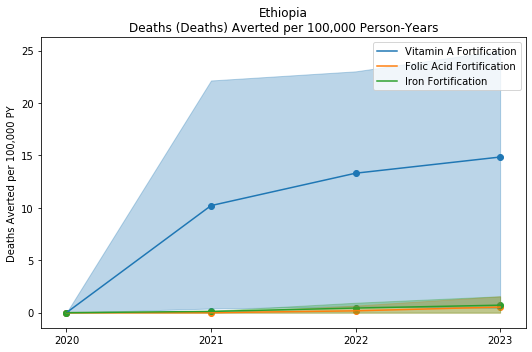

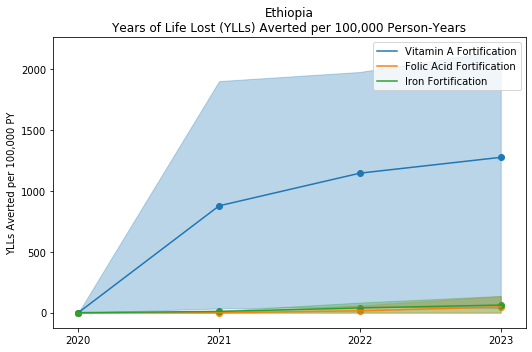

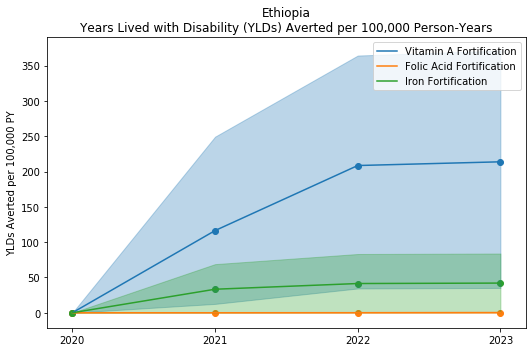

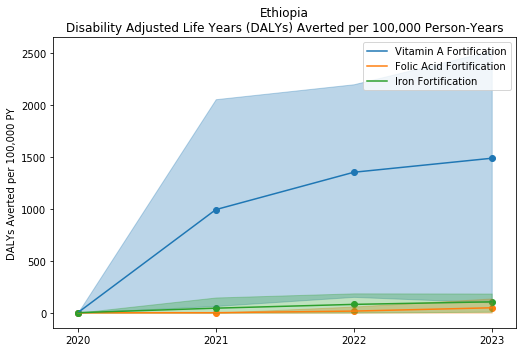

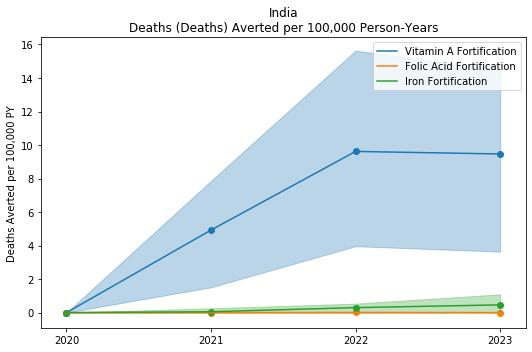

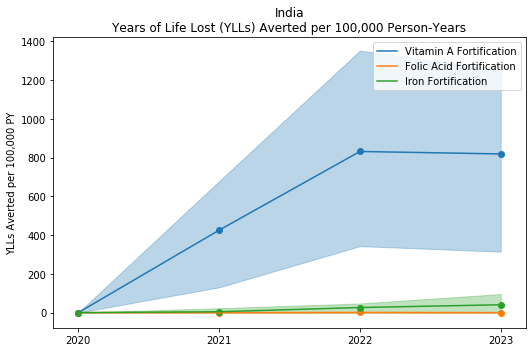

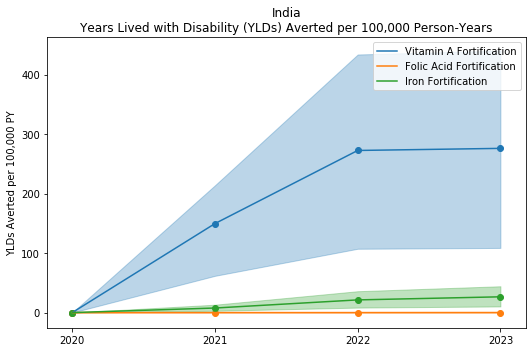

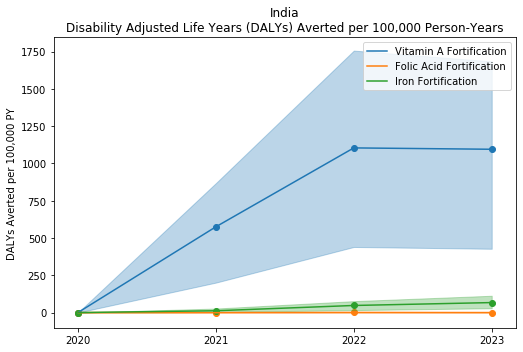

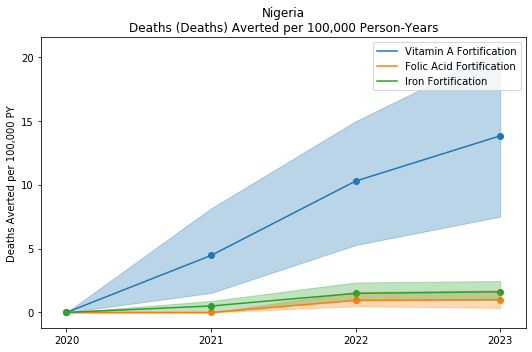

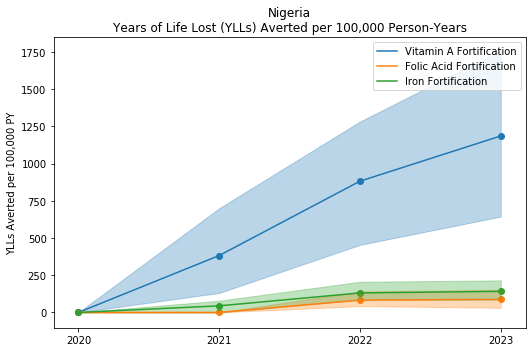

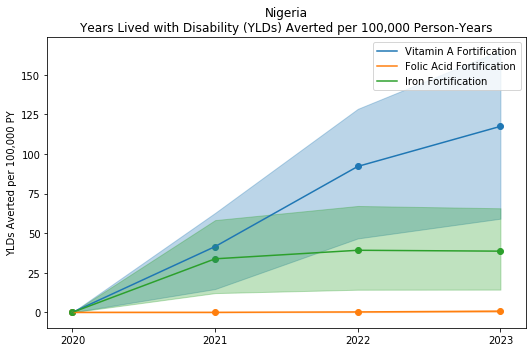

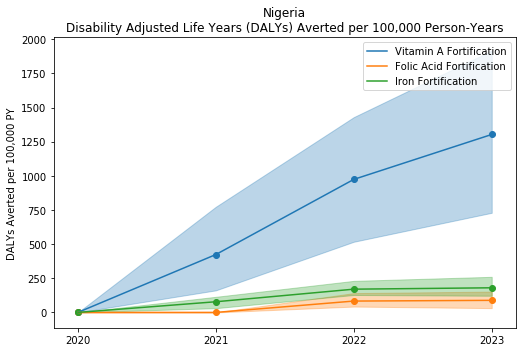

In [41]:
locations = ['Ethiopia','India',
             'Nigeria']

outcome_vars = ['deaths','ylls','ylds','dalys']

make_multiple_plots_by_year_by_location(by_year, locations, outcome_vars)

## 3. Results stratified by CAUSE (and not by year, uses *by_cause* dataframe)

In [42]:
def make_vitamin_a_affected_causes_averted_outcome_bar_charts(measure):
    
    data = pd.DataFrame.copy(by_cause)
    
    # bar width
    barWidth = 0.25
    
    data = data.loc[data.measure == measure]
    data = data.loc[data.scenario == 'vitamin_a_fortification_scale_up']
        
    data = data.groupby(['location','cause']).describe(percentiles=[0.1,0.9]).reset_index().sort_values(by='location')
    data1 = data.loc[data.cause == 'measles']
    data2 = data.loc[data.cause == 'lower_respiratory_infections']
    data3 = data.loc[data.cause == 'diarrheal_diseases']

    data1_mean = data1['value','mean']
    data2_mean = data2['value','mean']
    data3_mean = data3['value','mean']
    
    data1_10 = data1['value','mean'] - data1['value','10%']
    data2_10 = data2['value','mean'] - data2['value','10%']
    data3_10 = data3['value','mean'] - data3['value','10%']
    
    data1_90 = data1['value','90%'] - data1['value','mean']
    data2_90 = data2['value','90%'] - data2['value','mean']
    data3_90 = data3['value','90%'] - data3['value','mean']

    a = np.arange(len(data1))
    b = [x + barWidth for x in a]
    c = [x + barWidth for x in b]

    plt.bar(a, data1_mean, width=barWidth, yerr = [data1_10,data1_90])
    plt.bar(b, data2_mean, width=barWidth, yerr = [data2_10,data2_90])
    plt.bar(c, data3_mean, width=barWidth, yerr = [data3_10,data3_90])
    
    if measure == 'dalys':
        measure_title = 'Disability Adjusted Life Years (DALYs)'
    elif measure == 'ylds':
        measure_title = 'Years Lived With Disability (YLDs)'
    elif measure == 'ylls':
        measure_title = 'Years of Life Lost (YLLs)'
    else:
        measure_title = 'Deaths'
    
    plt.xticks([r + barWidth for r in range(len(data1))], np.unique(data1['location']))
    plt.ylabel(f'{measure_title}\n Averted per 100,000 PYs')
    plt.legend(['Measles','Lower Respiratory Infections','Diarrheal Diseases'])
    plt.title(f'{measure_title} Averted \n per 100,000 Person-Years')
    plt.tight_layout()
    plt.savefig(f'vitamin_a_affected_causes_averted_{measure}')

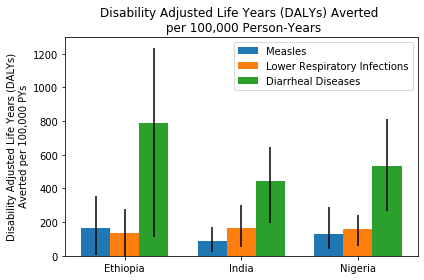

In [43]:
make_vitamin_a_affected_causes_averted_outcome_bar_charts('dalys')

In [46]:
def make_iron_affected_causes_averted_outcome_bar_charts(measure):
    
    data = pd.DataFrame.copy(by_cause)
    
    # bar width
    barWidth = 0.25
    
    data = data.loc[data.measure == measure]
    data = data.loc[data.scenario == 'iron_folic_acid_fortification_scale_up']
        
    data = data.groupby(['location','cause']).describe(percentiles=[0.1,0.9]).reset_index().sort_values(by='location')
    data1 = data.loc[data.cause == 'lower_respiratory_infections']
    data2 = data.loc[data.cause == 'diarrheal_diseases']
    data3 = data.loc[data.cause == 'other_causes']

    data1_mean = data1['value','mean']
    data2_mean = data2['value','mean']
    data3_mean = data3['value','mean']
    
    data1_min = data1['value','mean'] - data1['value','10%']
    data2_min = data2['value','mean'] - data2['value','10%']
    data3_min = data3['value','mean'] - data3['value','10%']
    
    data1_max = data1['value','90%'] - data1['value','mean']
    data2_max = data2['value','90%'] - data2['value','mean']
    data3_max = data3['value','90%'] - data3['value','mean']

    a = np.arange(len(data1))
    b = [x + barWidth for x in a]
    c = [x + barWidth for x in b]

    plt.bar(a, data1_mean, width=barWidth, yerr = [data1_min,data1_max])
    plt.bar(b, data2_mean, width=barWidth, yerr = [data2_min,data2_max])
    plt.bar(c, data3_mean, width=barWidth, yerr = [data3_min,data3_max])
    
    if measure == 'dalys':
        measure_title = 'Disability Adjusted Life Years (DALYs)'
    elif measure == 'ylds':
        measure_title = 'Years Lived With Disability (YLDs)'
    elif measure == 'ylls':
        measure_title = 'Years of Life Lost (YLLs)'
    else:
        measure_title = 'Deaths'
    
    plt.xticks([r + barWidth for r in range(len(data1))], np.unique(data1['location']))
    plt.ylabel(f'{measure_title}\n Averted per 100,000 PYs')
    plt.legend(['Lower Respiratory Infections','Diarrheal Diseases','Other Causes'])
    plt.title(f'{measure_title} Averted \n per 100,000 Person-Years')
    plt.tight_layout()
    plt.savefig(f'iron_affected_causes_averted_{measure}')

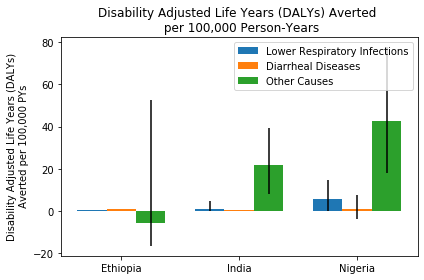

In [47]:
make_iron_affected_causes_averted_outcome_bar_charts('dalys')

In [50]:
def plot_results_by_cause(dataset, scenarios, outcome_vars, causes):
    for scenario in scenarios:
        for cause in causes:
            for outcome_var in outcome_vars:
                
                if outcome_var == 'dalys':
                    outcome_name_long = 'Disability Adjusted Life Years'
                    outcome_name_short = 'DALYs'
                elif outcome_var == 'ylls':
                    outcome_name_long = 'Years of Life Lost'
                    outcome_name_short = 'YLLs'
                elif outcome_var == 'ylds':
                    outcome_name_long = 'Years Lived with Disability'
                    outcome_name_short = 'YLDs'
                else:
                    outcome_name_long = 'Deaths'
                    outcome_name_short = 'Deaths'
                
                data = dataset.loc[dataset.scenario == scenario]
                data = data.loc[data.cause == cause]
                
                data = data.loc[data.measure == outcome_var]
                
                data = data.groupby(['location']).describe().reset_index().set_index('location')

                pos1 = 0.2
                pos2 = 0.4
                pos3 = 0.6    

                fig, ax = plt.subplots(figsize=(7.5, 5))

                plt.plot([(pos1 - 0.1),(pos3 + 0.1)],[0,0],'--',c='grey')

                plt.plot([pos1,pos1],[data['value','min'][0],data['value','max'][0]],c='black')
                plt.plot([pos2,pos2],[data['value','min'][1],data['value','max'][1]],c='black')
                plt.plot([pos3,pos3],[data['value','min'][2],data['value','max'][2]],c='black')
                plt.scatter([pos1,pos2,pos3],data['value','min'], marker='_',c='black',s=50)
                plt.scatter([pos1,pos2,pos3],data['value','max'], marker='_',c='black',s=50)         
                plt.scatter([pos1,pos2,pos3],data['value','mean'], s=100)

                scenario_title = scenario.replace('_',' ').capitalize()
                cause_title = cause.replace('_',' ').capitalize()

                plt.xticks([pos1,pos2,pos3], data.index)
                if outcome_var == 'deaths':
                    plt.title(f'{scenario_title}\n{outcome_name_long} due to {cause_title} Averted per 100,000 Person-Years')
                else:
                    plt.title(f'{scenario_title}\n{outcome_name_long} ({outcome_name_short}) due to {cause_title}\n Averted per 100,000 Person-Years')
                plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')
                plt.tight_layout()
                plt.savefig(f'dot_plot_{scenario}_{cause}_{outcome_var}')

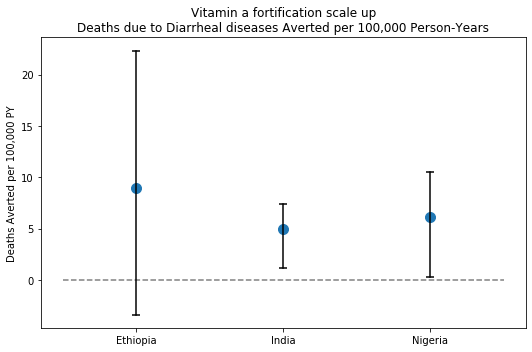

In [54]:
# fatal

scenarios = ['vitamin_a_fortification_scale_up']#,'folic_acid_fortification_scale_up','iron_folic_acid_fortification_scale_up']

outcome_vars = ['deaths']#,'ylls']

causes = ['diarrheal_diseases']#,
       #'lower_respiratory_infections', 'measles', 'neural_tube_defects',
       #'other_causes']

plot_results_by_cause(by_cause, scenarios, outcome_vars, causes)

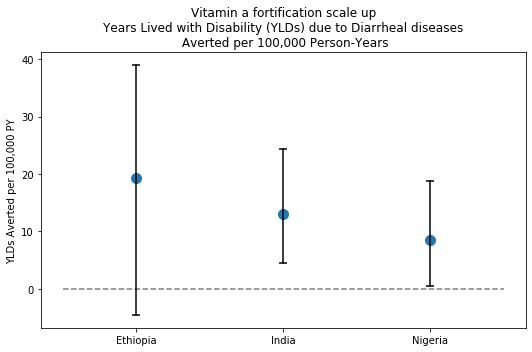

In [53]:
# non-fatal

scenarios = ['vitamin_a_fortification_scale_up']#,'folic_acid_fortification_scale_up','iron_folic_acid_fortification_scale_up']

outcome_vars = ['ylds']

causes = ['diarrheal_diseases']#,
       #'lower_respiratory_infections', 'measles', 'neural_tube_defects',
       #'iron_deficiency']

plot_results_by_cause(by_cause, scenarios, outcome_vars, causes)

## 4. Results by YEAR AND CAUSE

In [59]:
def make_multiple_plots_by_year_and_cause(dataset, scenarios, causes, outcome_vars):
    for scenario in scenarios:
        for outcome_var in outcome_vars:
            if outcome_var == 'dalys':
                outcome_name_long = 'Disability Adjusted Life Years'
                outcome_name_short = 'DALYs'
            elif outcome_var == 'ylls':
                outcome_name_long = 'Years of Life Lost'
                outcome_name_short = 'YLLs'
            elif outcome_var == 'ylds':
                outcome_name_long = 'Years Lived with Disability'
                outcome_name_short = 'YLDs'
            else:
                outcome_name_long = 'Deaths'
                outcome_name_short = 'Deaths'
            for cause in causes:

                data = dataset.loc[dataset.scenario == scenario]
                data = data.loc[data.cause == cause]
                data = data.loc[data.measure == outcome_var]
                data = data.groupby(['location','year']).describe(percentiles=[0.1,0.9]).reset_index()

                ethiopia = data.loc[data.location == 'Ethiopia']
                india = data.loc[data.location == 'India']
                nigeria = data.loc[data.location == 'Nigeria']

                fig, ax = plt.subplots(figsize=(7.5, 5))

                plt.scatter(ethiopia['year'], ethiopia['value','mean'])
                plt.plot(ethiopia['year'], ethiopia['value','mean'])

                plt.scatter(india['year'], india['value','mean'])
                plt.plot(india['year'], india['value','mean'])

                plt.scatter(nigeria['year'], nigeria['value','mean'])
                plt.plot(nigeria['year'], nigeria['value','mean'])

                plt.fill_between(ethiopia['year'],ethiopia['value','90%'],ethiopia['value','10%'], alpha=0.3,color='tab:blue')
                plt.fill_between(india['year'],india['value','90%'],india['value','10%'], alpha=0.3,color='tab:orange')
                plt.fill_between(nigeria['year'],nigeria['value','90%'],nigeria['value','10%'], alpha=0.3,color='tab:green')

                scenario_title = scenario.replace('_',' ').capitalize()
                cause_title = cause.replace('_',' ').capitalize()

                plt.title(f'{scenario_title}\n{outcome_name_long} ({outcome_name_short}) due to \n {cause_title} Averted per 100,000 Person-Years')
                plt.legend(['Ethiopia','India','Nigeria'])
                plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')
                plt.tight_layout()
                plt.savefig(f'{scenario}_{cause}_{outcome_var}_by_year.png')

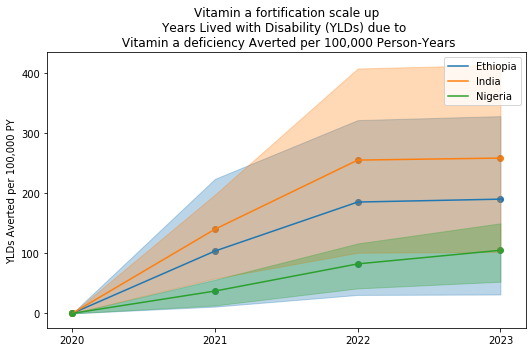

In [65]:
# VITAMIN A DEFICIENCY YLDS BY YEAR

scenarios = ['vitamin_a_fortification_scale_up']
causes = ['vitamin_a_deficiency']
outcome_vars = ['ylds']
make_multiple_plots_by_year_and_cause(by_year_and_cause, scenarios, causes, outcome_vars)

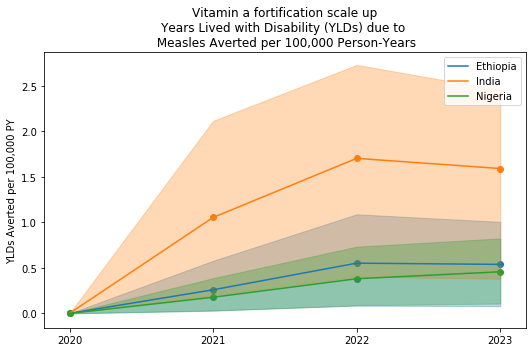

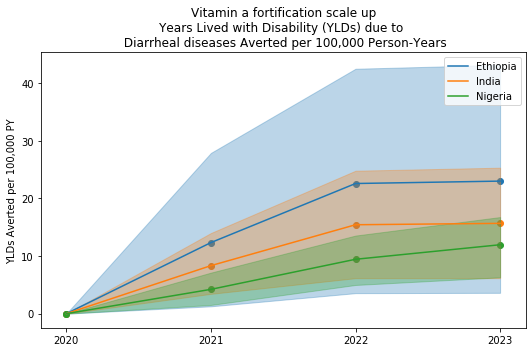

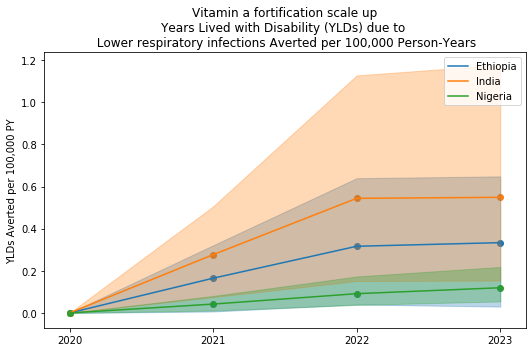

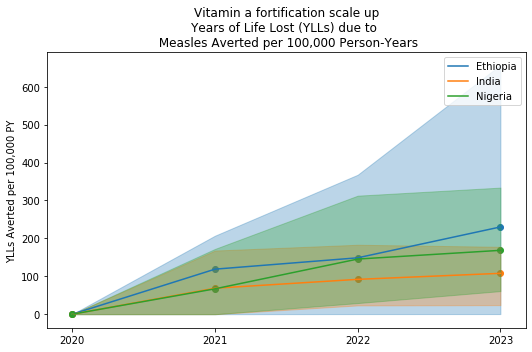

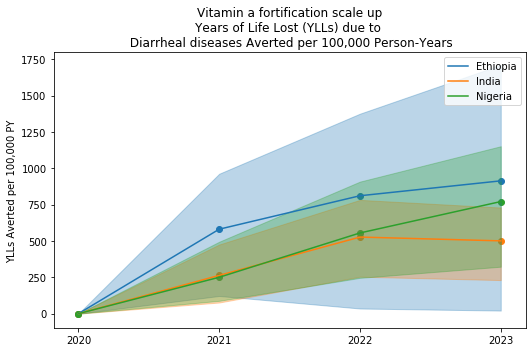

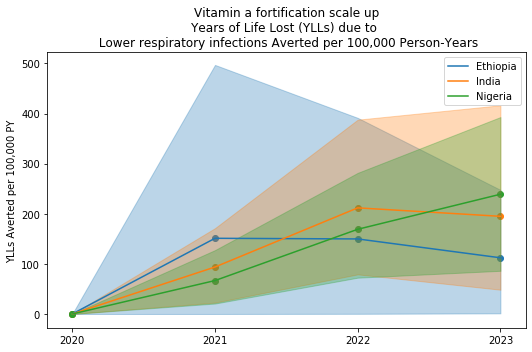

In [66]:
# VITAMIN A AFFECTED CAUSES YLDs and YLLs

scenarios = ['vitamin_a_fortification_scale_up']
causes = ['measles','diarrheal_diseases','lower_respiratory_infections']
outcome_vars = ['ylds','ylls']
make_multiple_plots_by_year_and_cause(by_year_and_cause, scenarios, causes, outcome_vars)

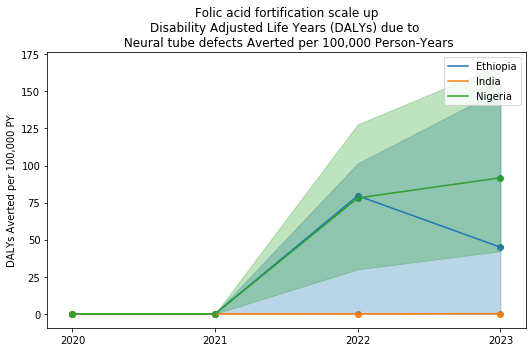

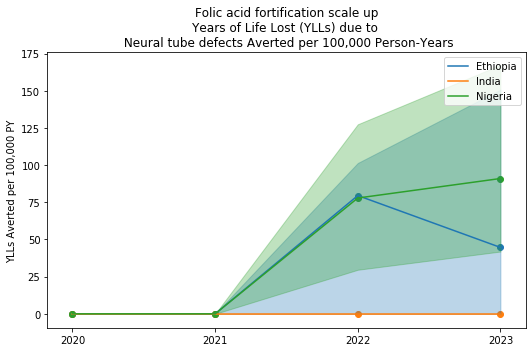

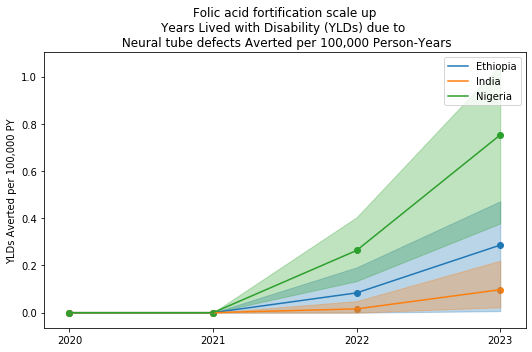

In [68]:
# FOLIC ACID NTD AVERTED DALYS, YLLs, YLDs

scenarios = ['folic_acid_fortification_scale_up']
causes = ['neural_tube_defects']
outcome_vars = ['dalys','ylls','ylds']
make_multiple_plots_by_year_and_cause(by_year_and_cause, scenarios, causes, outcome_vars)

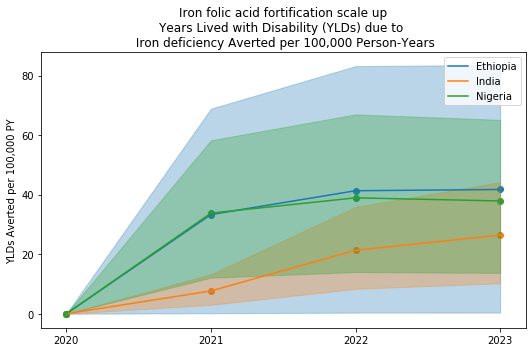

In [71]:
# IRON/IRON DEFICIENCY YLDS BY YEAR

scenarios = ['iron_folic_acid_fortification_scale_up']
causes = ['iron_deficiency']
outcome_vars = ['ylds']
make_multiple_plots_by_year_and_cause(by_year_and_cause, scenarios, causes, outcome_vars)

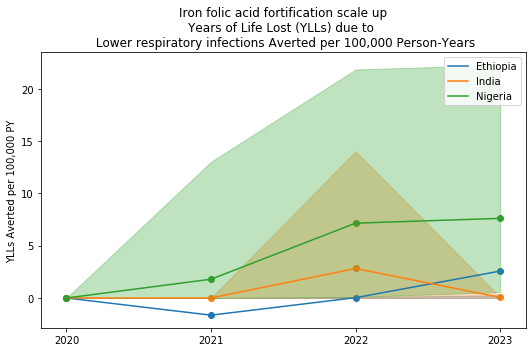

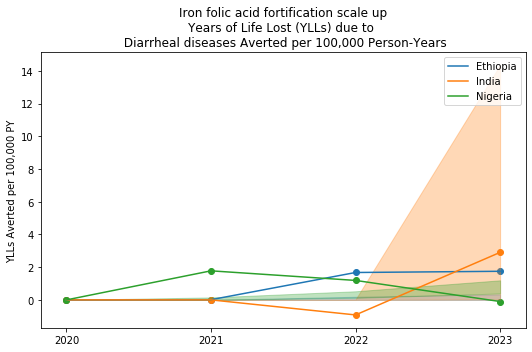

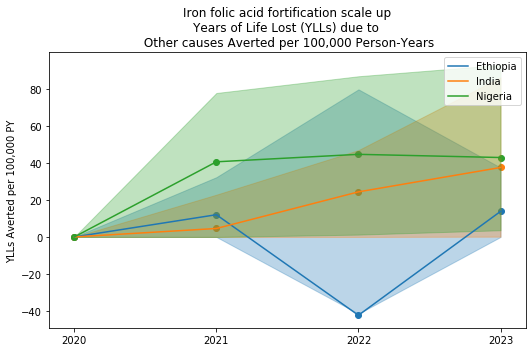

In [69]:
# IRON AFFECTED CAUSES YLDs BY YEAR

scenarios = ['iron_folic_acid_fortification_scale_up']
causes = ['lower_respiratory_infections','diarrheal_diseases','other_causes']
outcome_vars = ['ylls']
make_multiple_plots_by_year_and_cause(by_year_and_cause, scenarios, causes, outcome_vars)

# hmm... confidence intervals are looking really weird here, especially for diarrheal diseases
# see the dataframe below for closer investigation of the numbers

In [70]:
dataset = by_year_and_cause
cause = 'lower_respiratory_infections'
outcome_var = 'ylls'
scenario = 'iron_folic_acid_fortification_scale_up'

data = dataset.loc[dataset.scenario == scenario]
data = data.loc[data.cause == cause]
data = data.loc[data.measure == outcome_var]
data = data.groupby(['location','year']).describe(percentiles=[0.1,0.9]).reset_index()

ethiopia = data.loc[data.location == 'Ethiopia']
india = data.loc[data.location == 'India']
nigeria = data.loc[data.location == 'Nigeria']
ethiopia

# so here it looks like the mean value is actually higher than the 90th percentile
# indicating that value is HIGHLY skewed
# because these values are so erratic by year, we may want to consider not presenting these results 

location  year input_draw                                              \
                       count        mean         std   min    10%    50%   
0  Ethiopia  2020       14.0  524.428571  253.875716  29.0  225.7  563.0   
1  Ethiopia  2021       14.0  524.428571  253.875716  29.0  225.7  563.0   
2  Ethiopia  2022       14.0  524.428571  253.875716  29.0  225.7  563.0   
3  Ethiopia  2023       14.0  524.428571  253.875716  29.0  225.7  563.0   

                value                                                          \
     90%    max count          mean           std           min           10%   
0  800.2  946.0  14.0  1.982541e-13  1.619983e-12 -2.775558e-12 -1.387779e-12   
1  800.2  946.0  14.0 -1.641104e+00  6.168510e+00 -2.307276e+01 -3.747003e-12   
2  800.2  946.0  14.0  3.210005e-02  4.229052e-02 -2.775558e-12  0.000000e+00   
3  800.2  946.0  14.0  2.571569e+00  9.245971e+00 -5.551115e-12 -1.526557e-12   

                                         
        50%           90%           max  
0  0.000000  2.359224e-12  2.775558e-12  
1  0.000000  1.942890e-12  9.731192e-02  
2  0.016926  8.708042e-02  1.363286e-01  
3  0.108504  2.652565e-01  3.469432e+01